In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from ipywidgets import interact
import seaborn as sns


In [2]:
connection = sqlite3.connect('database.sqlite')
query_Country = "SELECT * FROM Country"
query_League = "SELECT * FROM League"
query_Match = "SELECT * FROM Match"
query_Player = "SELECT * FROM Player"
query_Player_Attributes = "SELECT * FROM Player_Attributes"
query_Team = "SELECT * FROM Team"
query_Team_Attributes = "SELECT * FROM Team_Attributes"
query_sqlite_sequence = "SELECT * FROM sqlite_sequence"



Identifier les attributs les plus intéressants à analyser :

Pour les joueurs : Taille, poids, potentiel, note globale, pied préféré.

Pour les équipes : Style de jeu, efficacité défensive, pression.

Pour les matchs : Scores, possession, et autres métriques de performance.

​

In [3]:
df_country = pd.read_sql(query_Country, connection)
df_league = pd.read_sql(query_League, connection)
df_compitition = pd.merge(df_country, df_league, on='id', how='inner')


In [4]:
df_compitition

,id,name_x,country_id,name_y
0,1,Belgium,1,Belgium Jupiler League
1,1729,England,1729,England Premier League
2,4769,France,4769,France Ligue 1
3,7809,Germany,7809,Germany 1. Bundesliga
4,10257,Italy,10257,Italy Serie A
5,13274,Netherlands,13274,Netherlands Eredivisie
6,15722,Poland,15722,Poland Ekstraklasa
7,17642,Portugal,17642,Portugal Liga ZON Sagres
8,19694,Scotland,19694,Scotland Premier League
9,21518,Spain,21518,Spain LIGA BBVA


In [5]:
df_player = pd.read_sql(query_Player, connection)
df_player['birthday'] = pd.to_datetime(df_player['birthday'], errors='coerce')
df_player['birthday'] = df_player['birthday'].dt.date


In [6]:
df_player_att = pd.read_sql(query_Player_Attributes, connection)
df_player_att['date'] = pd.to_datetime(df_player_att['date'])
df_player_att['date'] = df_player_att['date'].dt.date


In [7]:

# Relier les joueurs aux matchs
df_player_combined = pd.merge(df_player, df_player_att, on='player_api_id', how='inner')
df_player_combined.columns

Index(['id_x', 'player_api_id', 'player_name', 'player_fifa_api_id_x',
       'birthday', 'height', 'weight', 'id_y', 'player_fifa_api_id_y', 'date',
       'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [8]:

# Filtrer les colonnes pertinentes
columns_of_interest = ['player_name', 'height', 'weight', 'potential', 'overall_rating', 'preferred_foot']
df_filtered = df_player_combined[columns_of_interest]

# Fonction pour afficher un graphique pour un joueur
def plot_player_stats(player_name):
    # Filtrer les données du joueur
    player_data = df_filtered[df_filtered['player_name'] == player_name].iloc[0]
    
    # Créer les labels et les valeurs
    labels = ['Height (cm)', 'Weight (kg)', 'Potential', 'Overall Rating']
    values = [
        player_data['height'],
        player_data['weight'],
        player_data['potential'],
        player_data['overall_rating']
    ]
    
    # Créer le bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
    plt.title(f"Stats for {player_name} (Preferred Foot: {player_data['preferred_foot']})", fontsize=14)
    plt.ylabel("Value")
    plt.show()

# Liste des noms de joueurs uniques
player_names = df_filtered['player_name'].unique()

# Widget interactif
interact(plot_player_stats, player_name=player_names)


interactive(children=(Dropdown(description='player_name', options=('Aaron Appindangoye', 'Aaron Cresswell', 'A…

<function __main__.plot_player_stats(player_name)>

In [9]:
df_player_combined['date']=pd.to_datetime(df_player_combined['date'] , errors='coerce')
# df_player_combined['date']=df_player_combined['date'].dt.year

In [10]:
# Ensure the 'date' column is in datetime format
df_player_combined['date'] = pd.to_datetime(df_player_combined['date'])

# Create the 'season' column
def calculate_season(date):
    year = date.year
    if date.month >= 7:
        return f"{year}-{year+1}"
    else:
        return f"{year-1}-{year}"

df_player_combined['season'] = df_player_combined['date'].apply(calculate_season)

df_player_combined.columns[:100]
# print(df_player_combined[['potential', 'player_name', 'season']])


Index(['id_x', 'player_api_id', 'player_name', 'player_fifa_api_id_x',
       'birthday', 'height', 'weight', 'id_y', 'player_fifa_api_id_y', 'date',
       'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'season'],
      dtype='object')

In [11]:
# Group by 'season' and find the maximum potential for each season
max_potential_per_season = df_player_combined.groupby('season')['potential'].max().reset_index()

# Merge the max potential back with the original dataframe to get player details
most_performant_players = pd.merge(
    max_potential_per_season,
    df_player_combined,
    on=['season', 'potential'],
    how='inner'
)

# Select relevant columns for analysis
result = most_performant_players[['season', 'player_name', 'potential']].drop_duplicates()

# Sort by season
result = result.sort_values(by='season')

# Display the result
print(result)


       season          player_name  potential
0   2006-2007           Ronaldinho       95.0
1   2007-2008    Cristiano Ronaldo       94.0
2   2008-2009         Lionel Messi       95.0
4   2009-2010         Lionel Messi       95.0
5   2010-2011         Lionel Messi       95.0
6   2011-2012         Lionel Messi       96.0
8   2012-2013         Lionel Messi       97.0
11  2013-2014         Lionel Messi       97.0
14  2014-2015         Lionel Messi       95.0
19  2015-2016         Lionel Messi       95.0
20  2016-2017  Adalberto Penaranda       84.0


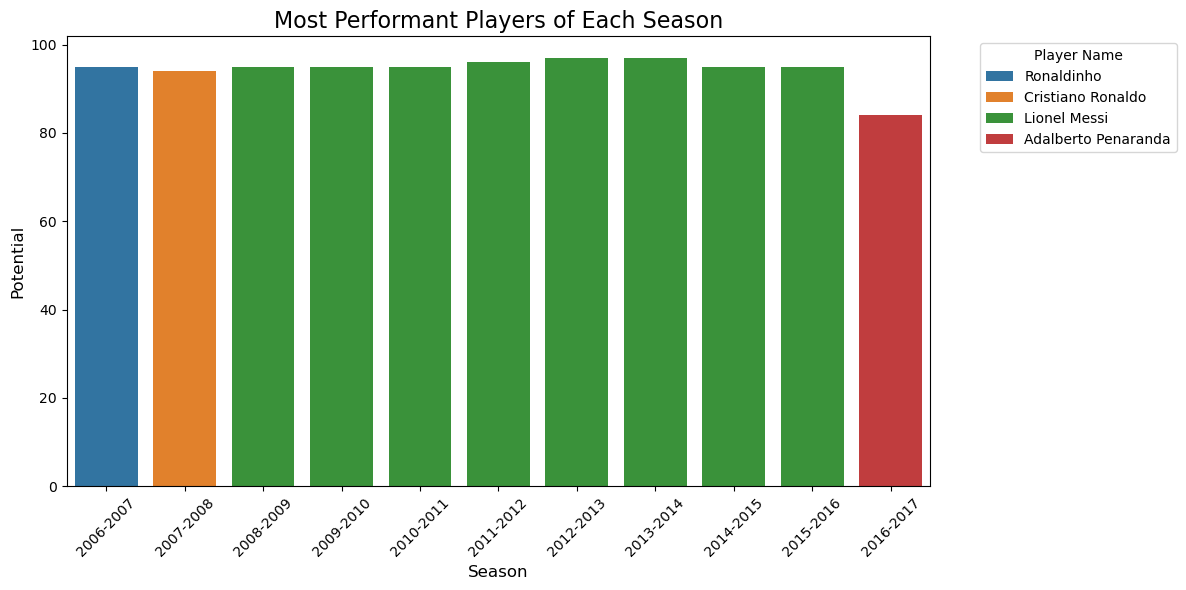

In [12]:
# Prepare the data
result = most_performant_players[['season', 'player_name', 'potential']].drop_duplicates()

# Set the plot style
plt.figure(figsize=(12, 6))
sns.barplot(
    data=result,
    x='season',
    y='potential',
    hue='player_name',  # Different colors for different players
    dodge=False
)

# Customize the plot
plt.title('Most Performant Players of Each Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Potential', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Player Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

Étape 1 : Identifier les attributs clés
Les attributs principaux pour évaluer la performance peuvent inclure :

Performance générale : overall_rating, potential.

Compétences techniques : short_passing, dribbling, ball_control, finishing.

Compétences physiques : acceleration, sprint_speed, stamina, strength.

Capacités défensives : marking, standing_tackle, sliding_tackle.

Capacités mentales : vision, positioning, reactions.

Étape 2 : Calculer une métrique pondérée

Attribuez des poids à chaque catégorie selon leur importance. Par exemple :

\text{Performance} = (0.4 \times \text{overall_rating}) + (0.3 \times \text{potential}) + (0.1 \times \text{physique}) + (0.1 \times \text{technique}) + (0.1 \times \text{mental})

Les sous-catégories peuvent être moyennées ou pondérées dans chaque groupe.

In [13]:

# Calcul des groupes de compétences
df_player_combined['physique'] = df_player_combined[['acceleration', 'sprint_speed', 'stamina', 'strength']].mean(axis=1)
df_player_combined['technique'] = df_player_combined[['short_passing', 'dribbling', 'ball_control', 'finishing']].mean(axis=1)
df_player_combined['mental'] = df_player_combined[['vision', 'positioning', 'reactions']].mean(axis=1)
df_player_combined['defense'] = df_player_combined[['marking', 'standing_tackle', 'sliding_tackle']].mean(axis=1)

# Calcul de la métrique globale
df_player_combined['performance_score'] = (
    0.4 * df_player_combined['overall_rating'] +
    0.3 * df_player_combined['potential'] +
    0.1 * df_player_combined['physique'] +
    0.1 * df_player_combined['technique'] +
    0.1 * df_player_combined['mental']
)

# Vérifiez les joueurs les plus performants par saison
most_performant = df_player_combined.groupby('season').apply(lambda x: x.nlargest(1, 'performance_score'))
most_performant


,,id_x,player_api_id,player_name,player_fifa_api_id_x,birthday,height,weight,id_y,player_fifa_api_id_y,date,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,season,physique,technique,mental,defense,performance_score
season,,,,,,,,,,,,,,,,,,,,,,
2006-2007,178975,10749,30829,Wayne Rooney,54050,1985-10-24,175.26,183,178976,54050,2007-02-22,...,7.0,71.0,11.0,12.0,2006-2007,91.00,89.00,86.666667,37.000000,91.766667
2007-2008,153452,9216,30743,Ronaldinho,28130,1980-03-21,182.88,168,153453,28130,2007-08-30,...,22.0,85.0,22.0,22.0,2007-2008,84.00,93.50,90.000000,23.000000,91.050000
2008-2009,102505,6176,30981,Lionel Messi,158023,1987-06-24,170.18,159,102506,158023,2008-08-30,...,20.0,79.0,20.0,20.0,2008-2009,83.00,92.25,87.666667,21.666667,90.791667
2009-2010,102503,6176,30981,Lionel Messi,158023,1987-06-24,170.18,159,102504,158023,2009-08-30,...,20.0,75.0,20.0,20.0,2009-2010,81.50,93.00,87.666667,20.333333,90.716667
2010-2011,102501,6176,30981,Lionel Messi,158023,1987-06-24,170.18,159,102502,158023,2010-08-30,...,11.0,15.0,14.0,8.0,2010-2011,79.00,93.25,90.000000,18.000000,90.725000
2011-2012,102499,6176,30981,Lionel Messi,158023,1987-06-24,170.18,159,102500,158023,2011-08-30,...,11.0,15.0,14.0,8.0,2011-2012,79.50,93.75,92.333333,18.000000,92.958333
2012-2013,102494,6176,30981,Lionel Messi,158023,1987-06-24,170.18,159,102495,158023,2013-03-22,...,11.0,15.0,14.0,8.0,2012-2013,82.75,94.75,93.000000,18.000000,93.750000
2013-2014,102491,6176,30981,Lionel Messi,158023,1987-06-24,170.18,159,102492,158023,2014-04-25,...,11.0,15.0,14.0,8.0,2013-2014,80.50,94.75,93.000000,22.000000,93.525000
2014-2015,102486,6176,30981,Lionel Messi,158023,1987-06-24,170.18,159,102487,158023,2015-03-13,...,11.0,15.0,14.0,8.0,2014-2015,80.75,93.75,92.000000,22.000000,92.350000


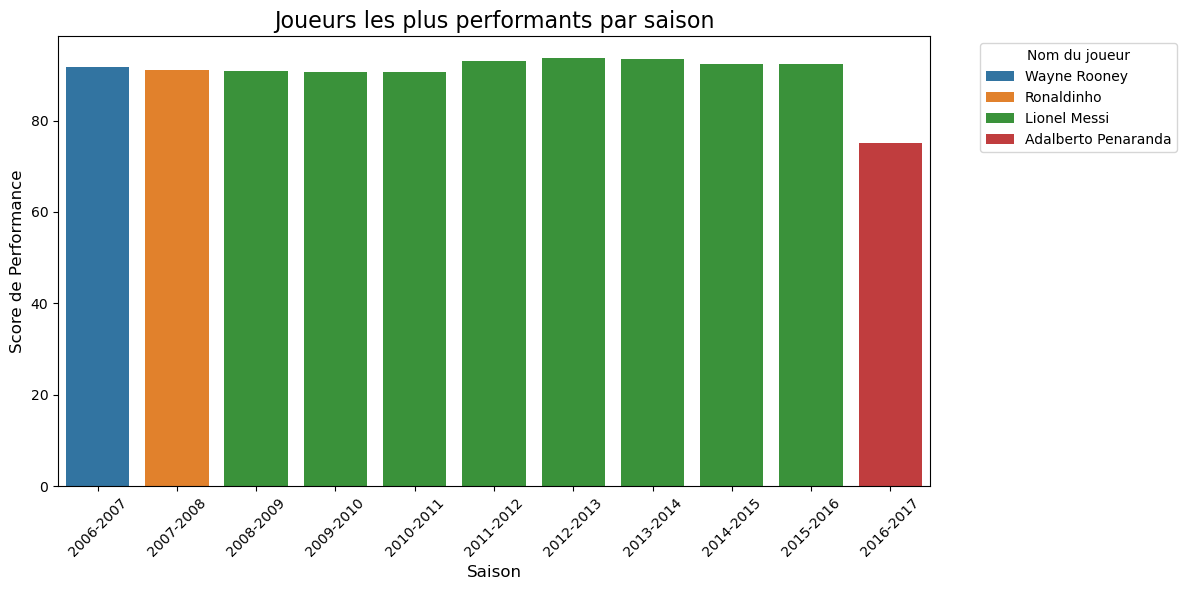

In [14]:

# Préparer les données
result = most_performant[['season', 'player_name', 'performance_score']].reset_index(drop=True)

# Tracer le graphique
plt.figure(figsize=(12, 6))
sns.barplot(data=result, x='season', y='performance_score', hue='player_name', dodge=False)

# Personnalisation
plt.title('Joueurs les plus performants par saison', fontsize=16)
plt.xlabel('Saison', fontsize=12)
plt.ylabel('Score de Performance', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Nom du joueur', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


Handle Missing Values for df_player_combined:


In [15]:
# List of numerical columns with missing values
columns_with_missing = ['agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
                        'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 
                        'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
                        'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes',
                        'physique', 'technique', 'mental', 'defense', 'performance_score']

# Loop through each column and fill missing values with the median of that column
for column in columns_with_missing:
    df_player_combined[column].fillna(df_player_combined[column].median(), inplace=True)


# Fill missing numerical values with the median for other columns
numerical_columns = ['overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy', 
                     'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 
                     'long_passing', 'ball_control', 'acceleration', 'sprint_speed']

# Loop through each numerical column and fill missing values with the median of that column
for column in numerical_columns:
    df_player_combined[column].fillna(df_player_combined[column].median(), inplace=True)

# Fill missing categorical values with the mode (most frequent value)
categorical_columns = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

# Loop through each categorical column and fill missing values with the mode
for column in categorical_columns:
    df_player_combined[column].fillna(df_player_combined[column].mode()[0], inplace=True)


In [16]:
# Count the number of missing values per column
missing_values = df_player_combined.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Only show columns with missing values
print("data cleaned \n", missing_values)


data cleaned 
 Series([], dtype: int64)


In [17]:
df_player_combined.columns

Index(['id_x', 'player_api_id', 'player_name', 'player_fifa_api_id_x',
       'birthday', 'height', 'weight', 'id_y', 'player_fifa_api_id_y', 'date',
       'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'season', 'physique', 'technique', 'mental', 'defense',
       'performance_score'],
      dtype='object')

In [18]:
# Ensure 'date' is in datetime format
df_player_combined['date'] = pd.to_datetime(df_player_combined['date'])

# Group by player and date, calculate the mean overall rating
df_overall_rating_per_day = df_player_combined.groupby(['player_name', 'date'])['overall_rating'].mean().reset_index()

# Rename columns for clarity
df_overall_rating_per_day.rename(columns={'overall_rating': 'overall_rating_per_day'}, inplace=True)

# Sort the results by player and date
df_overall_rating_per_day = df_overall_rating_per_day.sort_values(by=['player_name', 'date'])

# Display the results
print(df_overall_rating_per_day.head())


          player_name       date  overall_rating_per_day
0  Aaron Appindangoye 2007-02-22                    61.0
1  Aaron Appindangoye 2015-03-20                    61.0
2  Aaron Appindangoye 2015-09-21                    62.0
3  Aaron Appindangoye 2015-11-19                    67.0
4  Aaron Appindangoye 2016-02-18                    67.0


In [19]:
df_player_combined[['overall_rating'  , 'date' , 'player_name']]

,overall_rating,date,player_name
0,67.0,2016-02-18,Aaron Appindangoye
1,67.0,2015-11-19,Aaron Appindangoye
2,62.0,2015-09-21,Aaron Appindangoye
3,61.0,2015-03-20,Aaron Appindangoye
4,61.0,2007-02-22,Aaron Appindangoye
...,...,...,...
183973,83.0,2009-08-30,Zvjezdan Misimovic
183974,78.0,2009-02-22,Zvjezdan Misimovic
183975,77.0,2008-08-30,Zvjezdan Misimovic
183976,78.0,2007-08-30,Zvjezdan Misimovic


/tmp/ipykernel_505162/2122543429.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='player_name', y='std_dev', data=top_player_con, palette='viridis')


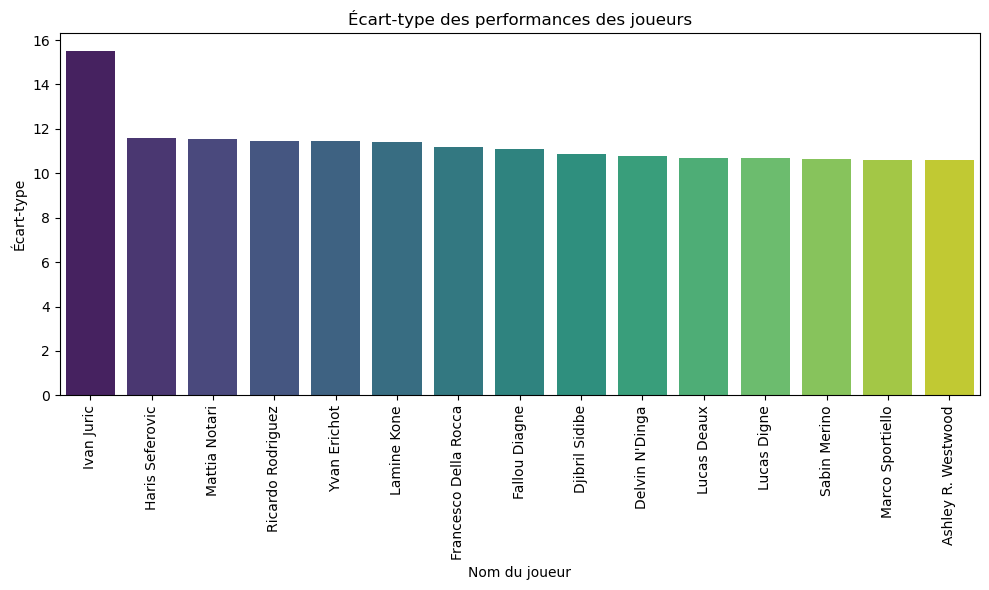

In [20]:
player_cons=df_overall_rating_per_day.groupby('player_name')['overall_rating_per_day'].agg(['std' , 'mean' , 'count']).reset_index()
player_cons.rename(columns={'std' : 'std_dev' , 'mean' : 'avg_rating' , 'count' : 'match_played'} , inplace=True)
player_cons=player_cons.sort_values(by='std_dev' , ascending=False)
top_player_con=player_cons.head(15)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='player_name', y='std_dev', data=top_player_con, palette='viridis')


plt.xticks(rotation=90)

plt.title('Écart-type des performances des joueurs')
plt.xlabel('Nom du joueur')
plt.ylabel('Écart-type')

plt.tight_layout()

plt.show()

Analyse des Équipes :

Quelles équipes dominent dans chaque ligue ?

Analysez les victoires, défaites, et matchs nuls pour identifier les équipes les plus efficaces.

Comparez les équipes en termes de styles de jeu : vitesse de construction, précision des passes, et pression défensive.

​

In [21]:
df_team = pd.read_sql(query_Team, connection)
df_team_att = pd.read_sql(query_Team_Attributes, connection)
df_team_combined = pd.merge(df_team, df_team_att, on='team_api_id', how='inner')

df_team_combined['date']=pd.to_datetime(df_team_combined['date'] , errors='coerce')
# df_player_combined['date']=df_player_combined['date'].dt.year


In [22]:
# Calculate a composite performance score for each team
performance_metrics = [
    'buildUpPlaySpeed', 'buildUpPlayPassing', 
    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
    'defencePressure', 'defenceAggression', 'defenceTeamWidth'
]

# Calculate total scores for each team
df_team_combined['performance_score'] = df_team_combined[performance_metrics].sum(axis=1)

# Group by team and calculate their average performance
team_performance = df_team_combined.groupby(['team_api_id', 'team_long_name'])['performance_score'].mean().reset_index()

# Sort by performance score
team_performance = team_performance.sort_values(by='performance_score', ascending=False)
print(team_performance.head(10))


     team_api_id          team_long_name  performance_score
125         8596                 Falkirk         540.000000
201         9860     Heart of Midlothian         479.600000
172         9789       Borussia Dortmund         469.333333
225         9925                  Celtic         465.833333
79          8429  Hamilton Academical FC         461.333333
234         9985       Standard de Liège         460.333333
198         9855        Grenoble Foot 38         460.000000
47          8191                 Burnley         459.666667
244         9999           KSV Roeselare         455.000000
156         8697        SV Werder Bremen         453.833333


In [23]:
# Assuming 'league_name' column is available after merging
# Group by league and find the team with the highest performance score
dominant_teams = df_team_combined.groupby('team_api_id').apply(
    lambda x: x.loc[x['performance_score'].idxmax(), ['team_long_name', 'performance_score']]
).reset_index()

# Rename columns for clarity
dominant_teams.rename(columns={'team_long_name': 'Dominant Team', 'performance_score': 'Score'}, inplace=True)

print(dominant_teams.head())


   team_api_id          Dominant Team  Score
0         1601           Ruch Chorzów    429
1         1773    Oud-Heverlee Leuven    396
2         1957  Jagiellonia Białystok    440
3         2033         S.C. Olhanense    415
4         2182            Lech Poznań    463


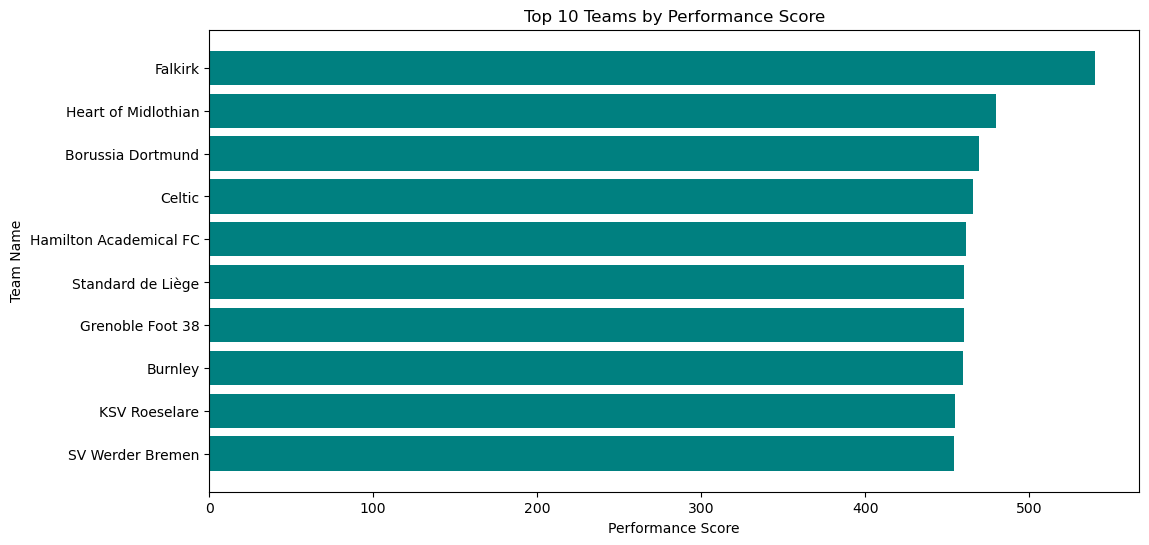

In [24]:

# Plot performance scores for the top teams
plt.figure(figsize=(12, 6))
plt.barh(team_performance['team_long_name'][:10], team_performance['performance_score'][:10], color='teal')
plt.xlabel('Performance Score')
plt.ylabel('Team Name')
plt.title('Top 10 Teams by Performance Score')
plt.gca().invert_yaxis()
plt.show()


In [25]:
df_merged = pd.merge(
    df_team_combined, 
    df_compitition, 
    left_on='team_api_id',  # Or another correct key
    right_on='id', 
    how='left'
)
df_merged

,id_x,team_api_id,team_fifa_api_id_x,team_long_name,team_short_name,id_y,team_fifa_api_id_y,date,buildUpPlaySpeed,buildUpPlaySpeedClass,...,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,performance_score,id,name_x,country_id,name_y
0,1,9987,673.0,KRC Genk,GEN,485,673,2010-02-22,45,Balanced,...,65,Press,70,Wide,Cover,440,NaN,NaN,NaN,NaN
1,1,9987,673.0,KRC Genk,GEN,486,673,2011-02-22,66,Balanced,...,47,Press,54,Normal,Offside Trap,449,NaN,NaN,NaN,NaN
2,1,9987,673.0,KRC Genk,GEN,487,673,2012-02-22,53,Balanced,...,45,Press,55,Normal,Cover,414,NaN,NaN,NaN,NaN
3,1,9987,673.0,KRC Genk,GEN,488,673,2013-09-20,58,Balanced,...,45,Press,55,Normal,Cover,414,NaN,NaN,NaN,NaN
4,1,9987,673.0,KRC Genk,GEN,489,673,2014-09-19,58,Balanced,...,45,Press,55,Normal,Cover,414,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,50201,9777,324.0,Servette FC,SER,1156,324,2013-09-20,48,Balanced,...,45,Press,49,Normal,Cover,406,NaN,NaN,NaN,NaN
1454,50204,7730,1862.0,FC Lausanne-Sports,LAU,672,1862,2010-02-22,30,Slow,...,60,Press,50,Normal,Cover,415,NaN,NaN,NaN,NaN
1455,50204,7730,1862.0,FC Lausanne-Sports,LAU,673,1862,2012-02-22,37,Balanced,...,43,Press,55,Normal,Cover,387,NaN,NaN,NaN,NaN
1456,50204,7730,1862.0,FC Lausanne-Sports,LAU,674,1862,2013-09-20,51,Balanced,...,43,Press,55,Normal,Cover,401,NaN,NaN,NaN,NaN


In [26]:
# Merge league information into df_team_combined
df_merged = pd.merge(
    df_team_combined, 
    df_compitition, 
    left_on='team_api_id',  # Adjust if needed
    right_on='id',          # Adjust column name for linking key
    how='left'
)

# Check the columns to verify the merge
print(df_merged.columns)

# Calculate performance score
performance_metrics = [
    'buildUpPlaySpeed', 'buildUpPlayPassing', 
    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
    'defencePressure', 'defenceAggression', 'defenceTeamWidth'
]
df_merged['performance_score'] = df_merged[performance_metrics].sum(axis=1)

# Group by league and team to calculate their average performance
league_team_performance = df_merged.groupby(['name_y', 'team_api_id', 'team_long_name'])['performance_score'].mean().reset_index()

# Sort by league and performance score in descending order
league_team_performance = league_team_performance.sort_values(['name_y', 'performance_score'], ascending=[True, False])

# Select the top 10 teams for each league
top_10_per_league = league_team_performance.groupby('name_y').head(10).reset_index(drop=True)

# Display the result
print(top_10_per_league)



Index(['id_x', 'team_api_id', 'team_fifa_api_id_x', 'team_long_name',
       'team_short_name', 'id_y', 'team_fifa_api_id_y', 'date',
       'buildUpPlaySpeed', 'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass', 'defenceDefenderLineClass',
       'performance_score', 'id', 'name_x', 'country_id', 'name_y'],
      dtype='object')
Empty DataFrame
Columns: [name_y, team_api_id, team_long_name, performance_score]
Index: []


In [27]:
# Calculate a composite performance score for each team
performance_metrics = [
    'buildUpPlaySpeed', 'buildUpPlayPassing', 
    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
    'defencePressure', 'defenceAggression', 'defenceTeamWidth'
]

# Calculate total scores for each team
df_team_combined['performance_score'] = df_team_combined[performance_metrics].sum(axis=1)

# Assuming `league_name` column exists (merged from df_competition)
# Group by league and team to calculate their average performance
league_team_performance = df_team_combined.groupby(['team_api_id', 'team_long_name'])['performance_score'].mean().reset_index()

# Sort by league and performance score in descending order
league_team_performance = league_team_performance.sort_values(['team_api_id', 'performance_score'], ascending=[True, False])

# Select the top 10 teams for each league
top_10_per_league = league_team_performance.groupby('team_api_id').head(10).reset_index(drop=True)

# Display the result
print(top_10_per_league)


     team_api_id         team_long_name  performance_score
0           1601           Ruch Chorzów         406.666667
1           1773    Oud-Heverlee Leuven         396.000000
2           1957  Jagiellonia Białystok         413.333333
3           2033         S.C. Olhanense         363.000000
4           2182            Lech Poznań         446.000000
..           ...                    ...                ...
283        10281        Real Valladolid         415.666667
284       108893       AC Arles-Avignon         350.833333
285       158085              FC Arouca         377.000000
286       208931                  Carpi         380.500000
287       274581   Royal Excel Mouscron         390.000000

[288 rows x 3 columns]


In [84]:
# df_team['team_long_name']
league_team_performance

,name_y,team_api_id,team_long_name,performance_score


In [85]:

# # Step 1: Merge league_team_performance with df_team on 'team_api_id' for team names
# performance_with_teams = pd.merge(
#     league_team_performance, df_team_combined, on="team_api_id", how="inner"
# )

# # Step 2: Merge the resulting DataFrame with df_competition for league names
# performance_with_leagues = pd.merge(
#     performance_with_teams, df_compitition, left_on="team_long_name_x", right_on="name_y", how="inner"
# )

# # Step 3: Filter top 10 teams per league based on performance_score
# top_10_per_league = (
#     performance_with_leagues.groupby("name_y", group_keys=False)
#     .apply(lambda x: x.nlargest(10, "performance_score"))
#     .reset_index(drop=True)
# )
# top_10_per_league
# # Step 4: Plot the results
# for league_name in top_10_per_league['name_y'].unique():
#     league_data = top_10_per_league[top_10_per_league['name_y'] == league_name]
#     plt.figure(figsize=(10, 6))
#     plt.barh(
#         league_data['team_long_name_x'], 
#         league_data['performance_score'], 
#         color='skyblue'
#     )
#     plt.xlabel('Performance Score')
#     plt.ylabel('Team Name')
#     plt.title(f'Top 10 Teams in {league_name}')
#     plt.gca().invert_yaxis()  # Invert y-axis for better readability
#     plt.show()

In [86]:
player_name = df_player[['player_api_id','player_name']]
Team_name = df_team[['team_api_id','team_long_name']]
League_name = df_league[['country_id','name']]

In [88]:
df_match = pd.read_sql(query_Match, connection)

match_columns = df_match[['league_id','stage','season','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal']]
analys_team = pd.merge(match_columns, Team_name, left_on='home_team_api_id', right_on='team_api_id', how='inner')
analys_team.drop(columns=['team_api_id', 'home_team_api_id'], inplace=True)

analys_team = analys_team.rename(columns={'team_long_name': 'home_team'})
analys_team = pd.merge(analys_team, Team_name, left_on='away_team_api_id', right_on='team_api_id', how='inner')
analys_team.drop(columns=['team_api_id', 'away_team_api_id'], inplace=True)
analys_team = analys_team.rename(columns={'team_long_name': 'away_team'})

analys_team = pd.merge(analys_team, League_name, left_on='league_id', right_on='country_id', how='inner')
analys_team.drop(columns=['league_id'], inplace=True)
analys_team = analys_team.rename(columns={'name': 'league_id'})

In [89]:
analys_team['result'] = analys_team.apply(lambda row: 'home' if row['home_team_goal'] > row['away_team_goal'] 
                        else ('away' if row['away_team_goal'] > row['home_team_goal'] 
                              else 'draw'), axis=1)

analys_team[analys_team['result']== 'draw'].count()

stage             6596
season            6596
home_team_goal    6596
away_team_goal    6596
home_team         6596
away_team         6596
country_id        6596
league_id         6596
result            6596
dtype: int64

In [90]:

home_results = analys_team.groupby(['league_id', 'home_team'])['result'].value_counts().unstack(fill_value=0)
# away_results = df.groupby(['league_id', 'away_team'])['away_result'].value_counts().unstack(fill_value=0)

In [94]:
home_results


result                                            away  draw  home
league_id                home_team                                
Belgium Jupiler League   Beerschot AC               21    25    30
                         Club Brugge KV             13    18    75
                         FCV Dender EH               8     4     5
                         KAA Gent                   27    19    63
                         KAS Eupen                   9     3     3
...                                                ...   ...   ...
Switzerland Super League FC Zürich                  43    38    62
                         Grasshopper Club Zürich    42    30    71
                         Lugano                      8     4     6
                         Neuchâtel Xamax            24    17    22
                         Servette FC                17     7    11

[296 rows x 3 columns]

In [95]:
# Reset index to prepare for plotting
home_results_reset = home_results.reset_index()

# Melt the DataFrame for easier visualization
home_results_melted = home_results_reset.melt(
    id_vars=['league_id', 'home_team'], 
    var_name='result', 
    value_name='count'
)


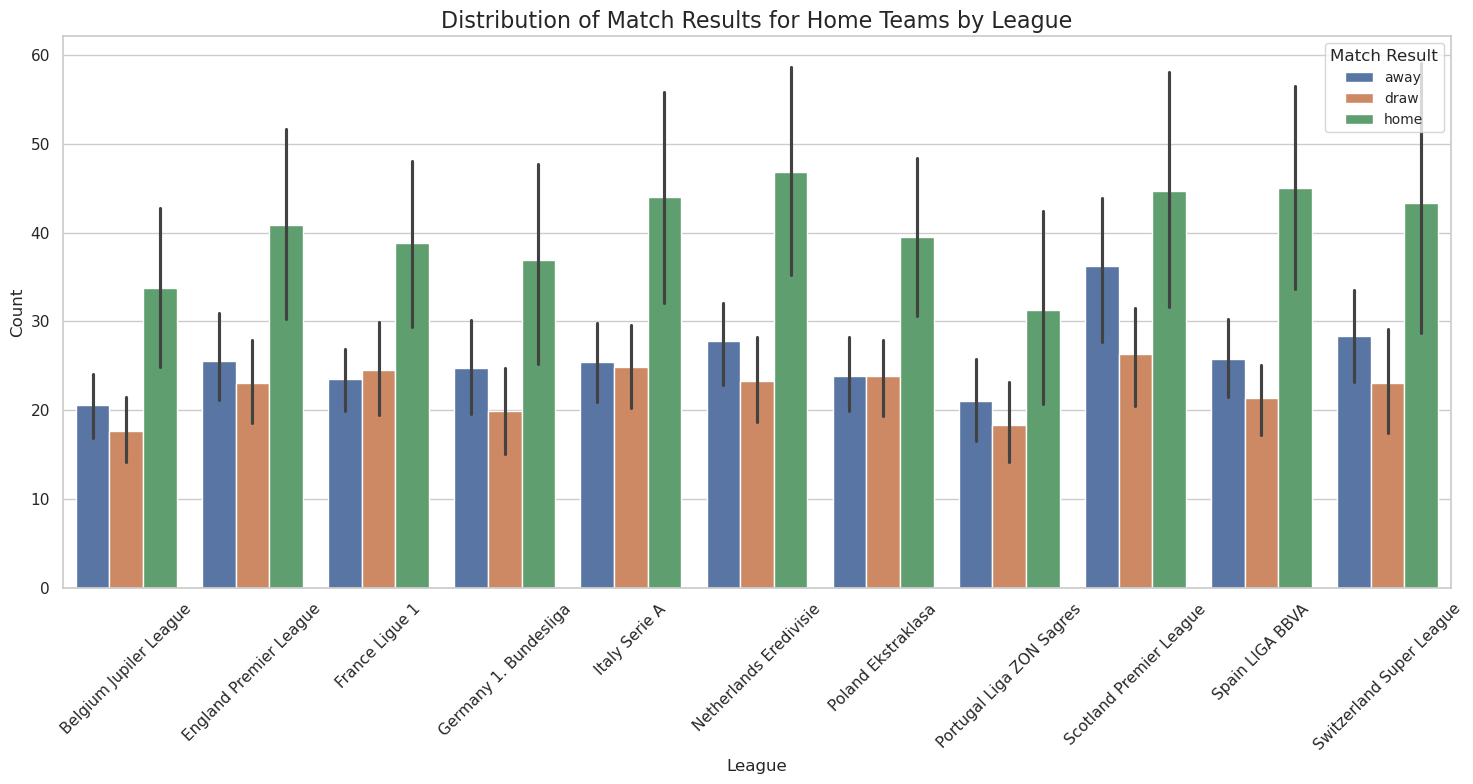

In [96]:
# Set the plot style
sns.set(style="whitegrid")

# Initialize the plot
plt.figure(figsize=(15, 8))

# Plot the data using a bar chart
sns.barplot(
    data=home_results_melted, 
    x='league_id', 
    y='count', 
    hue='result'
)

# Add plot labels and title
plt.title('Distribution of Match Results for Home Teams by League', fontsize=16)
plt.xlabel('League', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Match Result', loc='upper right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets, interact

# # Example DataFrames (replace with your actual data)
df_competition = pd.DataFrame({
    'name_y': ['England Premier League', 'Spain La Liga', 'Italy Serie A']
})  # Replace with your actual leagues data

# Placeholder top_10_per_league for demonstration
top_10_per_league = pd.DataFrame({
    'league_id': ['England Premier League'] * 10 + ['Spain La Liga'] * 10,
    'team_long_name': ['Team A', 'Team B', 'Team C', 'Team D', 'Team E',
                       'Team F', 'Team G', 'Team H', 'Team I', 'Team J'] * 2,
    'performance_score': [80, 78, 76, 74, 72, 70, 68, 66, 64, 62] * 2
})

# Interactive function to filter and plot data
def plot_top_teams(selected_league):
    # Filter top_10_per_league for the selected league
    filtered_data = top_10_per_league[top_10_per_league['league_id'] == selected_league]

    # Check if filtered data is not empty
    if not filtered_data.empty:
        # Plot the graph
        plt.figure(figsize=(10, 6))
        sns.barplot(data=filtered_data, x='performance_score', y='team_long_name', palette='viridis')
        plt.title(f"Top 10 Teams in {selected_league}")
        plt.xlabel("Performance Score")
        plt.ylabel("Team Name")
        plt.show()
    else:
        print("No data available for the selected league.")

# Dropdown widget for selecting a league
league_dropdown = widgets.Dropdown(
    options=df_compitition['name_y'].unique(),
    description='Select League:',
    style={'description_width': 'initial'}
)

# Interactive widget
interact(plot_top_teams, selected_league=league_dropdown)


interactive(children=(Dropdown(description='Select League:', options=('Belgium Jupiler League', 'England Premi…

<function __main__.plot_top_teams(selected_league)>

In [ ]:
# Function to plot a specific group of team attributes
def plot_team_attributes(team_name, attribute_group):
    # Filter data for the selected team
    team_data = df_team_combined[df_team_combined['team_long_name'] == team_name]
    if team_data.empty:
        print(f"No data available for team: {team_name}")
        return

    # Define attribute groups
    groups = {
        "Build-Up Play": [
            "buildUpPlaySpeed", "buildUpPlaySpeedClass", "buildUpPlayDribbling",
            "buildUpPlayDribblingClass", "buildUpPlayPassing", "buildUpPlayPassingClass",
            "buildUpPlayPositioningClass"
        ],
        "Chance Creation": [
            "chanceCreationPassing", "chanceCreationPassingClass",
            "chanceCreationCrossing", "chanceCreationCrossingClass",
            "chanceCreationShooting", "chanceCreationShootingClass",
            "chanceCreationPositioningClass"
        ],
        "Defense": [
            "defencePressure", "defencePressureClass", "defenceAggression",
            "defenceAggressionClass", "defenceTeamWidth", "defenceTeamWidthClass",
            "defenceDefenderLineClass"
        ],
    }

    if attribute_group not in groups:
        print(f"Invalid group: {attribute_group}")
        return

    attributes = groups[attribute_group]

    # Separate numeric and class attributes
    numeric_attributes = [attr for attr in attributes if attr in team_data.columns and team_data[attr].dtype in ["int64", "float64"]]
    class_attributes = [attr for attr in attributes if attr in team_data.columns and team_data[attr].dtype == "object"]

    # Prepare plot
    plt.figure(figsize=(10, 6))

    # Plot numeric attributes as bars
    if numeric_attributes:
        values = team_data[numeric_attributes].iloc[0]
        plt.bar(numeric_attributes, values, color='skyblue', label='Numeric Attributes')

    # Add qualitative information as text annotations
    y_pos = max(values) * 0.8 if numeric_attributes else 1  # Adjust y-position if numeric attributes exist
    for attr in class_attributes:
        class_value = team_data[attr].iloc[0]
        plt.text(
            len(numeric_attributes) / 2,  # Place in the middle of the bars
            y_pos,
            f"{attr}: {class_value}",
            fontsize=10,
            color='darkred',
            fontweight='bold',
        )
        y_pos -= max(values) * 0.2 if numeric_attributes else 0.2  # Adjust y spacing

    # Set plot title and labels
    plt.title(f"{attribute_group} for {team_name}", fontsize=14)
    plt.ylabel("Values")
    plt.xlabel("Attributes")
    plt.legend()
    plt.show()

# Ensure widget is created only once
# if 'team_group_interact_instance' not in globals():
team_names = df_team_combined['team_long_name'].dropna().unique()
groups = ["Build-Up Play", "Chance Creation", "Defense"]
team_group_interact_instance = interact(plot_team_attributes, team_name=team_names, attribute_group=groups)
# else:
#     print("Widget already created.")


interactive(children=(Dropdown(description='team_name', options=('KRC Genk', 'Beerschot AC', 'SV Zulte-Waregem…

In [ ]:
df_player_combined.columns

Index(['id_x', 'player_api_id', 'player_name', 'player_fifa_api_id_x',
       'birthday', 'height', 'weight', 'id_y', 'player_fifa_api_id_y', 'date',
       'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'season', 'physique', 'technique', 'mental', 'defense',
       'performance_score'],
      dtype='object')

Analyse des Joueurs : Quels sont les joueurs les plus performants de chaque saison ?



In [ ]:
df_match = pd.read_sql(query_Match, connection)
df_match['date']=pd.to_datetime(df_match['date'] , errors='coerce')
null_count = df_match['season'].isnull().sum()
# df_match.columns[:90]